In [1]:
import torch
import sys
sys.path.insert(0,'..')
from trcopo_optim import TRCoPO
from trcopo_optim import TRPO
from torch.distributions import Categorical
import numpy as np
from MatchingPennies.matching_pennies import pennies_game

from MatchingPennies.network import policy1, policy2

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

## Trust Region Competitive Policy Optimization

In [2]:
# Initialize policy for both agents for rock paper scissors
p1 = policy1() 
p2 = policy2()
for p in p1.parameters():
    print(p)
for p in p2.parameters():
    print(p)

Parameter containing:
tensor([0.9000, 0.1000], requires_grad=True)
Parameter containing:
tensor([0.2000, 0.9000], requires_grad=True)


In [3]:
# Initialisation of CPG and game environement
optim = TRCoPO(p1.parameters(),p2.parameters(), threshold=0.002)
env = pennies_game()

In [4]:
num_episode = 400
batch_size = 1000

<IPython.core.display.Javascript object>


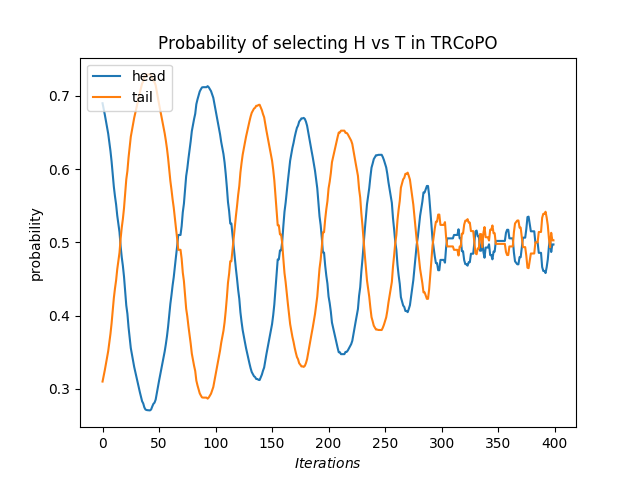

In [8]:
### Competitive Policy gradient
p1 = policy1() 
p2 = policy2()
# Initialisation of CPG and game environement
optim = TRCoPO(p1.parameters(),p2.parameters(), threshold=0.002)
env = pennies_game()

mat_head = []
mat_tail = []

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

for t_eps in range(num_episode):
    mat_action = []

    mat_state1 = []
    mat_reward1 = []
    mat_done = []

    mat_state2 = []
    mat_reward2 = []
    state, _, _, _, _ = env.reset()
    #data_collection
    for i in range(batch_size):
        pi1 = p1()
        dist1 = Categorical(pi1)
        action1 = dist1.sample()

        pi2 = p2()
        dist2 = Categorical(pi2)
        action2 = dist2.sample()
        action = np.array([action1, action2])

        state = np.array([0,0])
        mat_state1.append(torch.FloatTensor(state))
        mat_state2.append(torch.FloatTensor(state))
        mat_action.append(torch.FloatTensor(action))
        #print(action)

        state, reward1, reward2, done, _ = env.step(action)

        mat_reward1.append(torch.FloatTensor([reward1]))
        mat_reward2.append(torch.FloatTensor([reward2]))
        mat_done.append(torch.FloatTensor([1 - done]))

    #print(action)
    # print('a1',dist1.mean, dist1.variance)
    # print('a2',dist2.mean, dist2.variance)
    action_both = torch.stack(mat_action)
    
    mat_head.append(pi1.data[0])
    mat_tail.append(pi1.data[1])
    
    val1_p = torch.stack(mat_reward1).transpose(0,1)

    if val1_p.size(0)!=1:
        raise 'error'

    optim.zero_grad()

    def get_log_prob():
        pi_a1_s = p1()
        dist_pi1 = Categorical(pi_a1_s)
        action_both = torch.stack(mat_action)
        log_probs1 = dist_pi1.log_prob(action_both[:, 0])
        pi_a2_s = p2()
        dist_pi2 = Categorical(pi_a2_s)
        log_probs2 = dist_pi2.log_prob(action_both[:, 1])
        return log_probs1, log_probs2, val1_p

    improve1, improve2, lamda, lam1, lam2, esp, stat, its = optim.step(get_log_prob)

    _, _, cgx, cgy, itr_num = optim.getinfo()

    ax.clear()
    plt.title('Probability of selecting H vs T in TRCoPO')
    plt.xlabel('$Iterations$')
    plt.ylabel('probability')
    ax.plot(np.array(mat_head), label='head')
    ax.plot(np.array(mat_tail), label='tail')
    plt.legend(loc='upper left')
    fig.canvas.draw()

## Trust Region Gradient Descent Ascent

In [9]:
p1 = policy1()
p2 = policy2()
for p in p1.parameters():
    print(p)
for p in p2.parameters():
    print(p)
num_episode = 400
batch_size = 1000

Parameter containing:
tensor([0.9000, 0.1000], requires_grad=True)
Parameter containing:
tensor([0.2000, 0.9000], requires_grad=True)


<IPython.core.display.Javascript object>


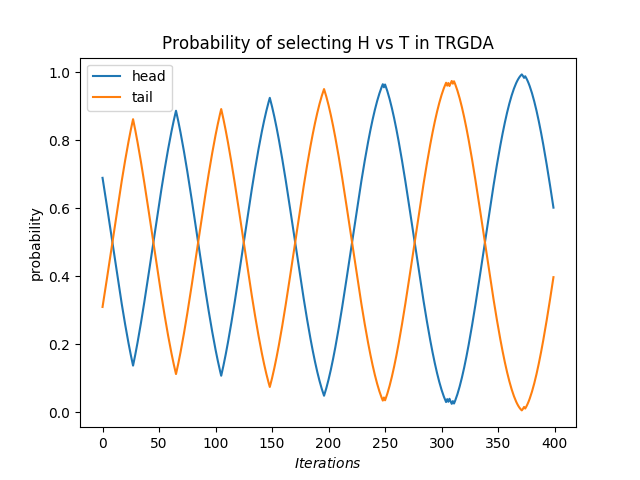

In [10]:
### Gradient descent ascent
p1 = policy1()
p2 = policy2()

optim_p1 = TRPO(p1, lam = 1, bound=1e-4, esp=0.001)
optim_p2 = TRPO(p2, lam = 1, bound=1e-4, esp=0.001)
env = pennies_game()

mat_head = []
mat_tail = []

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

for t_eps in range(num_episode):
    mat_action = []
    mat_state1 = []
    mat_reward1 = []
    mat_done = []
    mat_state2 = []
    mat_reward2 = []
    state, _, _, _, _ = env.reset()
    
    #data_collection
    for i in range(batch_size):
        pi1 = p1()
        dist1 = Categorical(pi1)
        action1 = dist1.sample()

        pi2 = p2()
        dist2 = Categorical(pi2)
        action2 = dist2.sample()
        action = np.array([action1, action2])

        state = np.array([0,0])
        mat_state1.append(torch.FloatTensor(state))
        mat_state2.append(torch.FloatTensor(state))
        mat_action.append(torch.FloatTensor(action))

        state, reward1, reward2, done, _ = env.step(action)
        mat_reward1.append(torch.FloatTensor([reward1]))
        mat_reward2.append(torch.FloatTensor([reward2]))
        mat_done.append(torch.FloatTensor([1 - done]))

    action_both = torch.stack(mat_action)
    val1_p = torch.stack(mat_reward1).transpose(0,1)

    def get_logprob1():
        pi_a1_s = p1()
        dist_pi1 = Categorical(pi_a1_s)
        log_probs1 = dist_pi1.log_prob(action_both[:, 0])
        return log_probs1, val1_p

    def get_logprob2():
        pi_a2_s = p2()
        dist_pi2 = Categorical(pi_a2_s)
        log_probs2 = dist_pi2.log_prob(action_both[:, 1])
        return log_probs2, -val1_p

    optim_p1.zero_grad()
    lam, improvement, a , sAs = optim_p1.step(get_logprob1)
    
    optim_p2.zero_grad()
    lam, improvement, a , sAs = optim_p2.step(get_logprob2)
        
    mat_head.append(pi1.data[0])
    mat_tail.append(pi1.data[1])
    
    ax.clear()
    plt.title('Probability of selecting H vs T in TRGDA')
    plt.xlabel('$Iterations$')
    plt.ylabel('probability')
    ax.plot(np.array(mat_head), label='head')
    ax.plot(np.array(mat_tail), label='tail')
    plt.legend(loc='upper left')
    fig.canvas.draw()